# Duration and Pitch Error Analysis

In this tutorial we will analyze the errors made by FastPitch in predicting duration and pitch

In [1]:
import json
import nemo
import torch
import time
import librosa
import numpy as np
import random

from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
!pip install seaborn

In [2]:
from nemo.collections.tts.models import FastPitchModel, MixerTTSModel
from nemo.collections.tts.torch.tts_tokenizers import GermanCharsTokenizer
from nemo.collections.tts.torch.helpers import beta_binomial_prior_distribution
# from nemo.collections.tts.torch.g2ps import EnglishG2p
from nemo.collections.asr.parts.preprocessing.segment import AudioSegment
import nemo.collections.asr as nemo_asr


import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

[NeMo W 2022-09-27 20:20:18 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
      warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
    
[NeMo W 2022-09-27 20:20:19 experimental:27] Module <class 'nemo.collections.tts.torch.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.


## Loading models

In [3]:
# spec_gen_2 = FastPitchModel.restore_from('/ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo')
spec_gen_2 = FastPitchModel.load_from_checkpoint('/ngc_results_backup/emotionaltts/c11e1-finetune-ssFastPitch-9emotions-emotions-local/2022-09-24_17-39-54/checkpoints/c11e1-finetune-ssFastPitch-9emotions-emotions-local--v_loss=0.8825-epoch=149.ckpt')
spec_gen_2 = spec_gen_2.eval().cuda()


[NeMo I 2022-09-27 20:20:20 tokenize_and_classify:81] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-09-27 20:20:37 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /DataEmotionalTTS/datasets_v2/openslr110/thorsten-emotional_v02/train_manifest_phonemes.json
      sample_rate: 22050
      sup_data_path: /DataEmotionalTTS/datasets_v2/openslr110/thorsten-emotional_v02/phonemes/
      sup_data_types:
      - align_prior_matrix
      - pitch
      - emotion_id
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004638671875
      pitch_norm: true
      pitch_mean:
      - 178.7041778564453
      - 224.8

[NeMo I 2022-09-27 20:20:37 features:200] PADDING: 1


In [4]:
from nemo.collections.tts.models import HifiGanModel

# ckpt = "/ngc_results_backup/emotionaltts/3281098-08242022_testc1e2_ngc/c1e2-HifiGAN-finetune2-pretrain-emotional/2022-08-25_15-17-39/checkpoints/c1e2-HifiGAN-finetune2-pretrain-emotional--val_loss=0.3183-epoch=4669.ckpt"
ckpt = "/ngc_results_backup/emotionaltts/3453996-09242022_testc11e1_ngc/c11e2-finetune-ssHiFiGan-De-emotions/2022-09-25_20-18-46/checkpoints/c11e2-finetune-ssHiFiGan-De-emotions--val_loss=0.3449-epoch=2329.ckpt"
vocoder_2 = HifiGanModel.load_from_checkpoint(ckpt)
vocoder_2 = vocoder_2.eval().cuda()

[NeMo W 2022-09-27 20:20:38 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /DataEmotionalTTS/thorsten-emotional_v02/predmels/hifigan_train_manifest_phonemes_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2022-09-27 20:20:38 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.Vocoder

[NeMo I 2022-09-27 20:20:38 features:200] PADDING: 0
[NeMo I 2022-09-27 20:20:38 features:208] STFT using exact pad
[NeMo I 2022-09-27 20:20:38 features:200] PADDING: 0
[NeMo I 2022-09-27 20:20:38 features:208] STFT using exact pad


## Loading data

In [5]:
import json
def json_reader(filename):
    with open(filename) as f:
        for line in f:
            yield json.loads(line)
            

def json_writer(file, json_objects):
    with open(file, "w") as f:
        for jsonobj in json_objects:
            jsonstr = json.dumps(jsonobj)
            f.write(jsonstr + "\n")

In [6]:
hifitts = list(json_reader('/DataEmotionalTTS/thorsten-emotional_v02/test_manifest_phonemes.json'))

In [7]:
emtns = set()
for h in hifitts:
    emtns.add(h['emotion_id'])

In [8]:
emtns

{1, 2, 3, 4, 5, 6, 7, 8}

## Helper functions

Get spectrogram from audio path

Wie berechnet man die optimale konvexe Hülle beliebiger Körper?


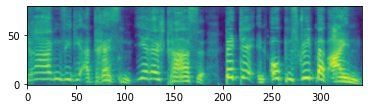

In [9]:
def get_mel_spect(
    n_fft = 1024,
    hop_len = 256,
    win_length = 1024,
    sample_rate = 22050,
    n_mels = 80,
    highfreq = 11000,
    lowfreq = 0,
    file_path = hifitts[0]['audio_filepath'],
    window = 'hann'
    ):

    audio = AudioSegment.from_file(
        file_path,
        target_sr=sample_rate,
        int_values=False,
        offset=0,
        duration=0,
        trim=False,
        orig_sr=None,
    )

    samples = []
#     if sample_rate == 44100:
#         samples = librosa.core.resample(audio.samples, orig_sr=44100, target_sr=22050)
    audio = torch.tensor(audio.samples, dtype=torch.float)
    #print("audio len {} {}".format(len(audio), len(samples)))

    window_fn = {
        'hann': torch.hann_window,
        'hamming': torch.hamming_window,
        'blackman': torch.blackman_window,
        'bartlett': torch.bartlett_window,
        'none': None,
    }.get(window, None)


    fb = torch.tensor(
        librosa.filters.mel(
            sr=sample_rate, n_fft=n_fft, n_mels=n_mels, fmin=lowfreq, fmax=highfreq
        ),
        dtype=torch.float,
    ).unsqueeze(0)

    stft = lambda x: torch.stft(
        input=x,
        n_fft=n_fft,
        hop_length=hop_len,
        win_length=win_length,
        window=window_fn(win_length, periodic=False).to(torch.float) if window_fn else None,
        return_complex=True,
    )

    spec = stft(audio)
    if spec.dtype in [torch.cfloat, torch.cdouble]:
        spec = torch.view_as_real(spec)
    spec = torch.sqrt(spec.pow(2).sum(-1) + 1e-9)
    mel = torch.matmul(fb.to(spec.dtype), spec)
    log_mel = torch.log(torch.clamp(mel, min=torch.finfo(mel.dtype).tiny))
    return log_mel.cpu().detach().numpy()[0,...], audio, len(audio), len(samples)

mel, _, _, _ = get_mel_spect()
imshow(mel, origin="lower")
print(hifitts[4]['normalized_text'])

Setup Tokenizer

In [10]:
# phoneme_dict_path="scripts/tts_dataset_files/cmudict-0.7b_nv22.07"
# heteronyms_path="scripts/tts_dataset_files/heteronyms-030921"
    
# g2p = EnglishG2p(
#     phoneme_dict=phoneme_dict_path,
#     heteronyms=heteronyms_path
# )

# Text tokenizer
text_tokenizer = GermanCharsTokenizer(
    punct=True,
    apostrophe=True,
    pad_with_space=True,
    phonemes=True
)

alignment prior matrix

In [11]:
EPSILON = 1e-9

stft = lambda x: torch.stft(
        input=x,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        window=torch.hann_window(1024, periodic=False).to(torch.float),
        return_complex=True,
    )

fb = torch.tensor(
        librosa.filters.mel(
            sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=11000
        ),
        dtype=torch.float,
    ).unsqueeze(0)

def get_spec(audio):
    with torch.cuda.amp.autocast(enabled=False):
        spec = stft(audio)
        if spec.dtype in [torch.cfloat, torch.cdouble]:
            spec = torch.view_as_real(spec)
        spec = torch.sqrt(spec.pow(2).sum(-1) + EPSILON)
    return spec


def get_log_mel(audio):
    with torch.cuda.amp.autocast(enabled=False):
        spec = get_spec(audio)
        mel = torch.matmul(fb.to(spec.dtype), spec)
        log_mel = torch.log(torch.clamp(mel, min=torch.finfo(mel.dtype).tiny))
    return log_mel

def get_align_prior_matrix(audio):
    mel_len = get_log_mel(audio).shape[2]
    align_prior_matrix = beta_binomial_prior_distribution(text_length, mel_len)
    align_prior_matrix = torch.from_numpy(align_prior_matrix)
    return align_prior_matrix

def get_pitch(audio, win_length=1024, pitch_fmin=73.4161911, pitch_fmax=2093.0046386, sample_rate=22050):
    voiced_tuple = librosa.pyin(
        audio.numpy(),
        fmin=pitch_fmin,
        fmax=pitch_fmax,
        frame_length=win_length,
        sr=sample_rate,
        fill_na=0.0,
    )
    return voiced_tuple

## Calculate error

In [12]:
spec_gen_2 = spec_gen_2.eval()
phone_duration_error = {}
phone_pitch_error = {}
emotion_duration_error = {}
emotion_duration_sec_error = {}
emotion_duration_error_normalized = {}
emotion_pitch_error = {}

for i, sample in enumerate(hifitts):
    np_spec, audio, audio_len, sample_len = get_mel_spect(file_path=sample['audio_filepath'])
    spec = torch.from_numpy(np_spec).cuda()
    
    # Tokenize
    tokenized = text_tokenizer(sample["normalized_text"])
    text = torch.tensor(tokenized).long().cuda()
    text_length = torch.tensor(len(tokenized)).long()

    align_mat_prior = get_align_prior_matrix(audio).cuda()
    text_length = text_length.cuda()
    voiced_tuple = get_pitch(audio)
    pitch = torch.from_numpy(voiced_tuple[0])
    emotion = torch.tensor([sample['emotion_id']]).cuda()
    
    # With spec and attn_prior as input - as happens during training
    with torch.no_grad():
        out = spec_gen_2.forward(
            text=text.unsqueeze(0),
            durs=None,
            pitch=None,
            spec=spec.unsqueeze(0),
            attn_prior=align_mat_prior.unsqueeze(0),
            mel_lens=torch.tensor(audio_len).long().cuda().unsqueeze(0),
            input_lens=text_length.unsqueeze(0),
            emotion=emotion
        )
        
    _, _, durs_predicted, _, pitch_predicted, _, _, attn_hard, attn_hard_dur, _ = out
    pitch_errors = []
    for txt in range(text.size()[0]):
        p = text[txt].item()
        er = abs(durs_predicted[0][txt].item() - attn_hard_dur[0][txt].item())
        p_er = abs(pitch[txt].item() - pitch_predicted[0][txt].item())
        if p not in phone_duration_error:
            phone_duration_error[p] = []
            phone_pitch_error[p] = []
        phone_pitch_error[p].append(p_er)
        pitch_errors.append(p_er)
        phone_duration_error[p].append(er)
        
        
    tot_err = abs(attn_hard_dur.sum().item() - durs_predicted.sum().item())
    if sample["emotion_id"] not in emotion_duration_error:
        emotion_duration_error[sample["emotion_id"]] = []
        emotion_duration_error_normalized[sample["emotion_id"]] = []
        emotion_pitch_error[sample["emotion_id"]] = []
    emotion_duration_error[sample["emotion_id"]].append(tot_err)
    emotion_duration_error_normalized[sample["emotion_id"]].append(tot_err/attn_hard_dur.sum().item())
    emotion_pitch_error[sample["emotion_id"]].append(sum(pitch_errors)/len(pitch_errors))
    
    with torch.no_grad():
        out = spec_gen_2.forward(
            text=text.unsqueeze(0),
            durs=None,
            pitch=None,
            input_lens=text_length.unsqueeze(0),
            emotion=emotion
        )
        
    spec_pred, _, _, _, _, _, _, _, _, _ = out
    
    audio_oiginal = vocoder_2.convert_spectrogram_to_audio(spec=spec.unsqueeze(0))
    audio_pred = vocoder_2.convert_spectrogram_to_audio(spec=spec_pred)
    if sample["emotion_id"] not in emotion_duration_sec_error:
        emotion_duration_sec_error[sample["emotion_id"]] = []
    emotion_duration_sec_error[sample["emotion_id"]].append(abs(audio_oiginal.size()[1]/22050 - audio_pred.size()[1]/22050))
    
    if i % 100 == 0:
        print(f"... done {i} steps")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


... done 0 steps
... done 400 steps


[NeMo W 2022-09-27 20:35:09 tts_tokenizers:144] Text: [viː ʃɛtsən ziː diː ʃɑ̃sən aɪn zoː aɪnən pɾoːtsɛs tsuː ɡəvɪnən ] contains unknown char: [̃]. Symbol will be skipped.


... done 500 steps
... done 600 steps
... done 700 steps
... done 800 steps
... done 900 steps


In [13]:
pitch_predicted.size(), durs_predicted.size()

(torch.Size([1, 33]), torch.Size([1, 33]))

In [14]:
emotion_duration_sec_error_l = []
for k,v in emotion_duration_sec_error.items():
    emotion_duration_sec_error_l = emotion_duration_sec_error_l + v

In [15]:
emotion_duration_error_l = []
for k,v in emotion_duration_error.items():
    emotion_duration_error_l = emotion_duration_error_l + v

In [16]:
normalized_l = []
for k,v in emotion_duration_error_normalized.items():
    normalized_l = normalized_l + v

In [17]:
phone_error = []
for k,v in phone_duration_error.items():
    phone_error.append(float(sum(v) / len(v)))
x_labels = [text_tokenizer.tokens[k] for k in list(phone_duration_error.keys())]

In [18]:
emotion_dur_error = []
for k,v in emotion_duration_sec_error.items():
    emotion_dur_error.append(float(sum(v) / len(v)))

In [19]:
emtn_error = []
for k,v in emotion_duration_error.items():
    emtn_error.append(float(sum(v) / len(v)))

In [20]:
phone_pitch_error_l = []
for k,v in phone_pitch_error.items():
    phone_pitch_error_l.append(float(sum(v) / len(v)))
x_labels_p = [text_tokenizer.tokens[k] for k in list(phone_pitch_error.keys())]

In [21]:
emtn_pitch_error = []
for k,v in emotion_pitch_error.items():
    emtn_pitch_error.append(float(sum(v) / len(v)))

In [22]:
emotion_pitch_error_l = []
for k,v in emotion_pitch_error.items():
    emotion_pitch_error_l = emotion_pitch_error_l + v

## Duration Error Visualization

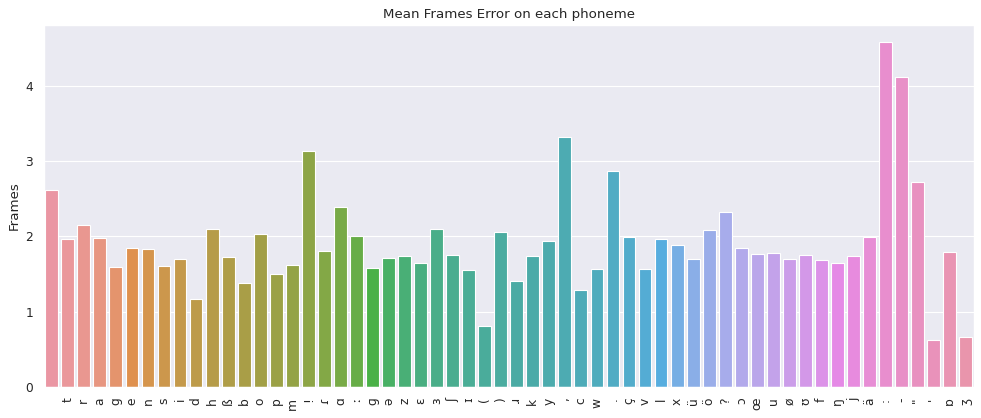

In [23]:
plt.figure(figsize=(15, 6), dpi=80)
sns.set(font_scale = 1.0)
ax = sns.barplot(x=x_labels, y=phone_error)
ax.set(title='Mean Frames Error on each phoneme', ylabel="Frames")
plt.xticks(rotation=90)
plt.show()

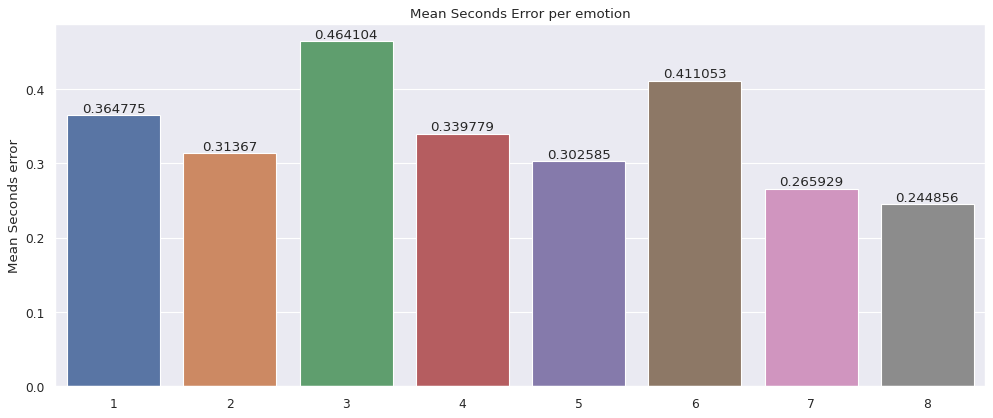

In [24]:
plt.figure(figsize=(15, 6), dpi=80)
ax = sns.barplot(x=list(emtns), y=emotion_dur_error)
ax.set(title='Mean Seconds Error per emotion', ylabel="Mean Seconds error")
ax.bar_label(ax.containers[0])
plt.show()

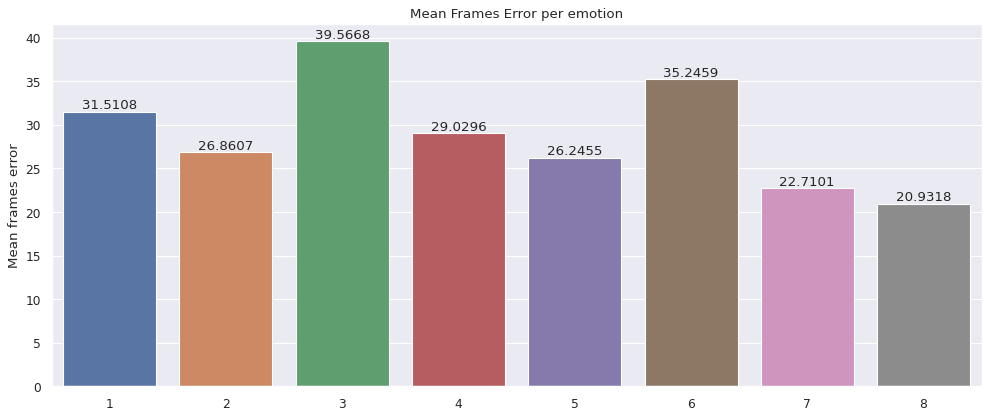

In [25]:
plt.figure(figsize=(15, 6), dpi=80)
ax = sns.barplot(x=list(emtns), y=emtn_error)
ax.set(title='Mean Frames Error per emotion', ylabel="Mean frames error")
ax.bar_label(ax.containers[0])
plt.show()

<Figure size 1200x480 with 0 Axes>

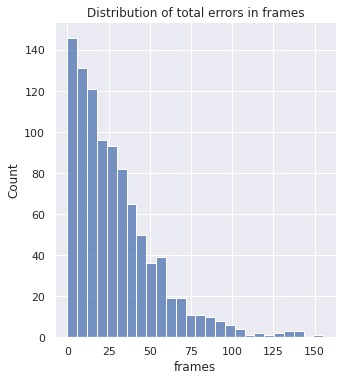

In [26]:
plt.figure(figsize=(15, 6), dpi=80)
ax = sns.displot(x=emotion_duration_error_l) #, kind="kde")
ax.set(title='Distribution of total errors in frames', xlabel="frames")
plt.show()

<Figure size 1200x480 with 0 Axes>

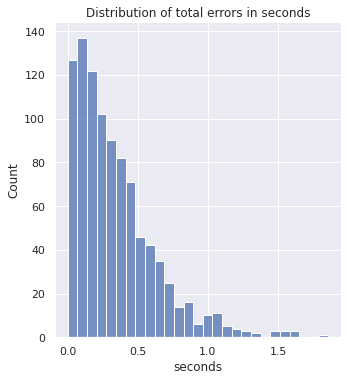

In [27]:
plt.figure(figsize=(15, 6), dpi=80)
ax = sns.displot(x=emotion_duration_sec_error_l) #, kind="kde")
ax.set(title='Distribution of total errors in seconds', xlabel="seconds")
plt.show()

<Figure size 1200x480 with 0 Axes>

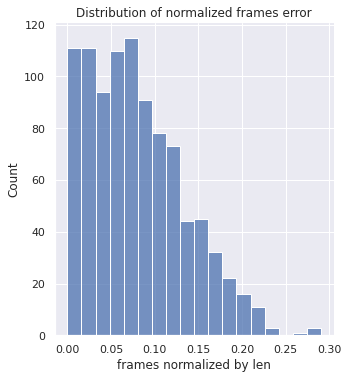

In [28]:
plt.figure(figsize=(15, 6), dpi=80)
ax = sns.displot(x=normalized_l) #, kind="kde")
ax.set(title='Distribution of normalized frames error', xlabel="frames normalized by len")
plt.show()

## Pitch Error Visualization

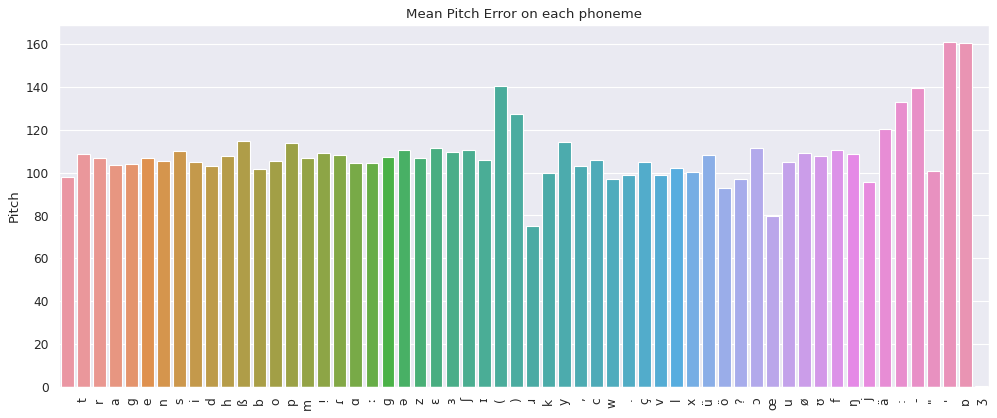

In [29]:
plt.figure(figsize=(15, 6), dpi=80)
sns.set(font_scale = 1.0)
ax = sns.barplot(x=x_labels_p, y=phone_pitch_error_l)
ax.set(title='Mean Pitch Error on each phoneme', ylabel="Pitch")
plt.xticks(rotation=90)
plt.show()

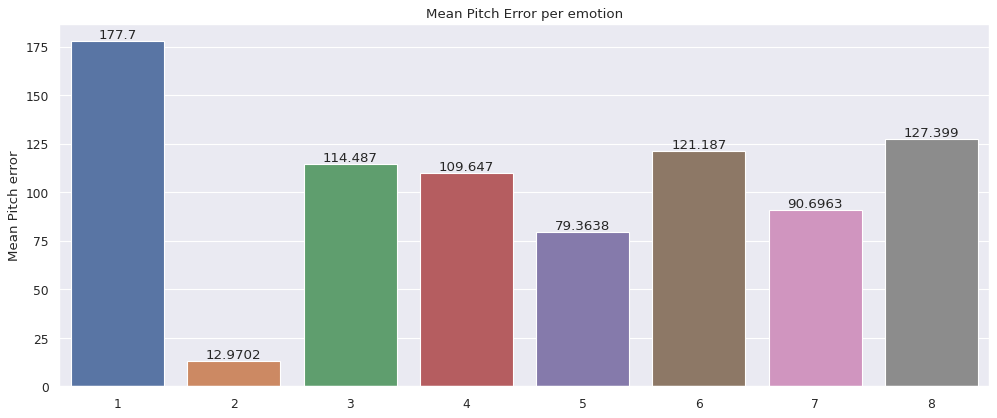

In [30]:
plt.figure(figsize=(15, 6), dpi=80)
ax = sns.barplot(x=list(emtns), y=emtn_pitch_error)
ax.set(title='Mean Pitch Error per emotion', ylabel="Mean Pitch error")
ax.bar_label(ax.containers[0])
plt.show()

<Figure size 1200x480 with 0 Axes>

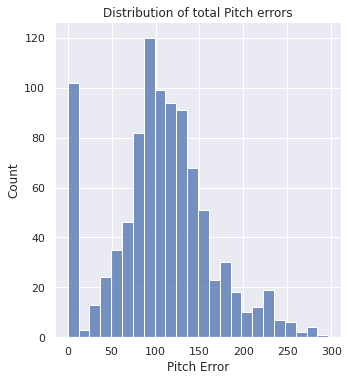

In [ ]:
plt.figure(figsize=(15, 6), dpi=80)
ax = sns.displot(x=emotion_pitch_error_l) #, kind="kde")
ax.set(title='Distribution of total Pitch errors', xlabel="Pitch Error")
plt.show()